# Metodos de ensamble

Carlos Patricio Castaneda Bustamante 

Maestria en ingenieria en computacion / Universidad Autonoma de Chihuahua

## Librerias

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

## Preprocesamiento y separacion de datos

is_hazardous              1.000000
relative_velocity         0.266009
estimated_diameter_min    0.263725
estimated_diameter_max    0.263725
miss_distance            -0.008683
absolute_magnitude       -0.564632
Name: is_hazardous, dtype: float64

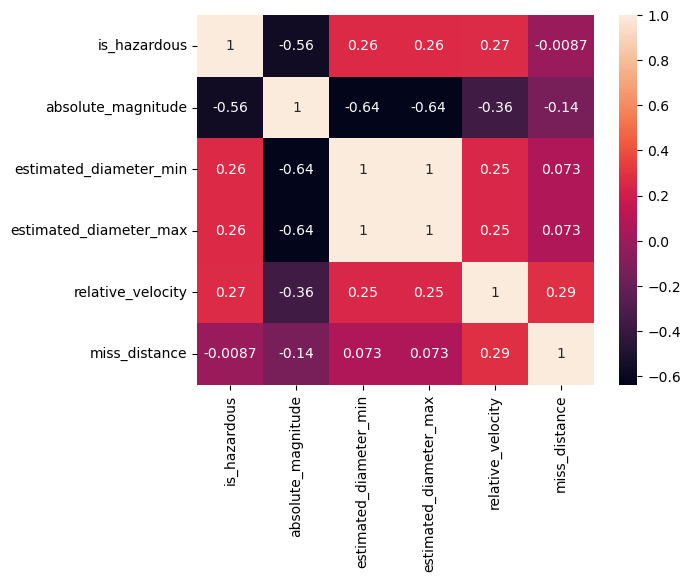

In [4]:
df = pd.read_csv('/Volumes/Maestria/GitHub/NEO/NEO/nearest-earth-objects(1910-2024).csv')

df.drop(columns=['neo_id', 'orbiting_body', 'name'], inplace=True)
le = LabelEncoder()
df['is_hazardous'] = le.fit_transform(df['is_hazardous'])
df = df.dropna()
df_test = df.copy()
sm = SMOTE(sampling_strategy='minority', random_state=42)
oversampled_X, oversampled_Y = sm.fit_resample(df_test.drop('is_hazardous', axis=1), df_test['is_hazardous'])
df = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

df_target = df['is_hazardous']
df_target_array = df_target.values
df_features = df.drop(columns=['is_hazardous'])
df_features_array = df_features.values

preprocess = ColumnTransformer([
    ('scaler', StandardScaler(), ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance'])
])

pipeline = Pipeline([
    ('preprocess', preprocess)])

df_preprocessed = pipeline.fit_transform(df)
df_preprocessed


X_train, X_test, y_train, y_test = train_test_split(df_preprocessed, df_target_array, test_size=0.2)

sss = StratifiedShuffleSplit(n_splits=1, test_size=20000, random_state=42)

for train_index, sample_index in sss.split(X_train, y_train):
    X_train_sample = X_train[sample_index]
    y_train_sample = y_train[sample_index]


sns.heatmap(df.corr(), annot=True)

corr_matrix = df.corr()

corr_matrix['is_hazardous'].sort_values(ascending=False)

## Ensamble

### VotingClassifier

Se creaa un ensamble con la estrategia de voting, el cual va a tomar los 3 modelos que hemos entrenado, con sus respectivos parametros optimos que se encontraron anteriormente.

Despues, separamos las estrategias entre un "hard voting" y un "soft voting"

#### Hard voting

In [8]:
log_clf = LogisticRegression(C=0.001, fit_intercept=False, n_jobs=8, random_state=0, solver='lbfgs', warm_start=True)
rnd_clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', random_state=42)
svm_clf = SVC(C=10000, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_sample, y_train_sample)

ensemble_predictions = voting_clf.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
cm = confusion_matrix(y_test, ensemble_predictions)
cm1 = cm / cm.sum(axis=1)[:, np.newaxis]
print(f"Ensemble Accuracy: {ensemble_accuracy}")
print("Ensemble Confusion Matrix:")
sns.heatmap(cm1, annot=True, cmap='Blues')

# Evaluate individual classifiers
for clf_name, clf in voting_clf.named_estimators_.items():
    clf.fit(X_train_sample, y_train_sample)  # Ensure each classifier is fitted
    individual_predictions = clf.predict(X_test)
    individual_accuracy = accuracy_score(y_test, individual_predictions)
    individual_conf_matrix = confusion_matrix(y_test, individual_predictions)
    print(f"Accuracy of {clf_name}: {individual_accuracy}")
    print(f"Confusion Matrix of {clf_name}:")
    print(individual_conf_matrix)


Ensemble Accuracy: 0.886325887258059
Ensemble Confusion Matrix:
[[48896 10015]
 [ 3399 55694]]
Accuracy of lr: 0.8133792074844921
Confusion Matrix of lr:
[[41315 17596]
 [ 4426 54667]]
Accuracy of rf: 0.8881478593945968
Confusion Matrix of rf:
[[50342  8569]
 [ 4630 54463]]
Accuracy of svc: 0.8824531371817904
Confusion Matrix of svc:
[[52383  6528]
 [ 7343 51750]]


#### Soft Voting

In [9]:
log_clf = LogisticRegression(C=0.001, fit_intercept=False, n_jobs=8, random_state=0, solver='lbfgs', warm_start=True)
rnd_clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', random_state=42)
svm_clf = SVC(C=10000, random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train_sample, y_train_sample)

ensemble_predictions = voting_clf.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
cm = confusion_matrix(y_test, ensemble_predictions)
cm1 = cm / cm.sum(axis=1)[:, np.newaxis]
print(f"Ensemble Accuracy: {ensemble_accuracy}")
print("Ensemble Confusion Matrix:")
sns.heatmap(cm1, annot=True, cmap='Blues')

# Evaluate individual classifiers
for clf_name, clf in voting_clf.named_estimators_.items():
    clf.fit(X_train_sample, y_train_sample)  # Ensure each classifier is fitted
    individual_predictions = clf.predict(X_test)
    individual_accuracy = accuracy_score(y_test, individual_predictions)
    individual_conf_matrix = confusion_matrix(y_test, individual_predictions)
    print(f"\nAccuracy of {clf_name}: {individual_accuracy}")
    print(f"Confusion Matrix of {clf_name}:")
    print(individual_conf_matrix)


Ensemble Accuracy: 0.8857242127385513
Ensemble Confusion Matrix:
[[47950 10961]
 [ 2524 56569]]

Accuracy of lr: 0.8133792074844921
Confusion Matrix of lr:
[[41315 17596]
 [ 4426 54667]]

Accuracy of rf: 0.8881478593945968
Confusion Matrix of rf:
[[50342  8569]
 [ 4630 54463]]

Accuracy of svc: 0.8824531371817904
Confusion Matrix of svc:
[[52383  6528]
 [ 7343 51750]]


### Bagging

#### Bagging

Ensemble Accuracy: 0.8796566218094302
Ensemble Confusion Matrix:


<Axes: >

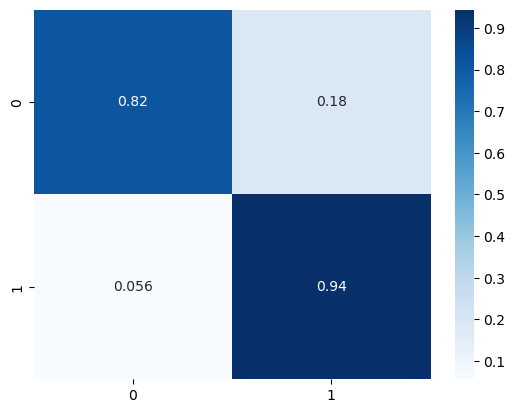

In [15]:
bag_clf = BaggingClassifier(
    RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', random_state=42),
    n_estimators=100,
    random_state=42, 
    bootstrap=True
)
bag_clf.fit(X_train_sample, y_train_sample)
ensemble_predictions = bag_clf.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
cm = confusion_matrix(y_test, ensemble_predictions)
cm1 = cm / cm.sum(axis=1)[:, np.newaxis]
print(f"Ensemble Accuracy: {ensemble_accuracy}")
print("Ensemble Confusion Matrix:")
sns.heatmap(cm1, annot=True, cmap='Blues')


#### Pasting

Ensemble Accuracy: 0.8876139791871462
Ensemble Confusion Matrix:


<Axes: >

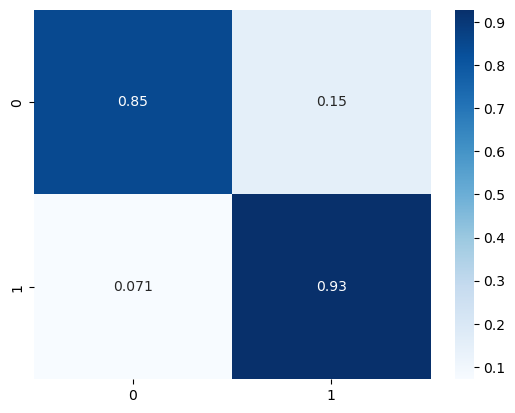

In [16]:
bag_clf = BaggingClassifier(
    RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', random_state=42),
    n_estimators=100,
    random_state=42, 
    bootstrap=False
)
bag_clf.fit(X_train_sample, y_train_sample)
ensemble_predictions = bag_clf.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
cm = confusion_matrix(y_test, ensemble_predictions)
cm1 = cm / cm.sum(axis=1)[:, np.newaxis]
print(f"Ensemble Accuracy: {ensemble_accuracy}")
print("Ensemble Confusion Matrix:")
sns.heatmap(cm1, annot=True, cmap='Blues')


### AdaBoost

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Ensemble Accuracy: 0.8868851903325311
Ensemble Confusion Matrix:


<Axes: >

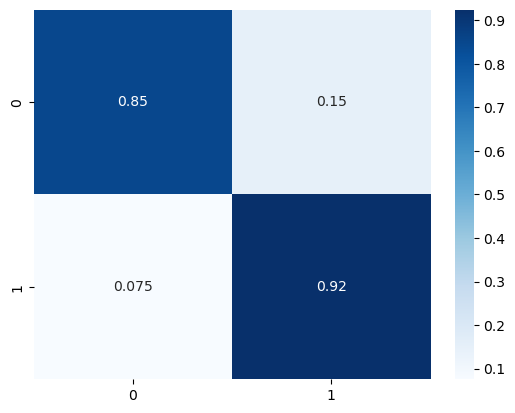

In [22]:
ada_clf = AdaBoostClassifier(
    RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', random_state=42),
    n_estimators=100,
    random_state=42, 
    learning_rate=0.1
)
ada_clf.fit(X_train_sample, y_train_sample)

ensemble_predictions = ada_clf.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
cm = confusion_matrix(y_test, ensemble_predictions)
cm1 = cm / cm.sum(axis=1)[:, np.newaxis]
print(f"Ensemble Accuracy: {ensemble_accuracy}")
print("Ensemble Confusion Matrix:")
sns.heatmap(cm1, annot=True, cmap='Blues')

### Gradient Boost

Ensemble Accuracy: 0.8580217619741703
Ensemble Confusion Matrix:


<Axes: >

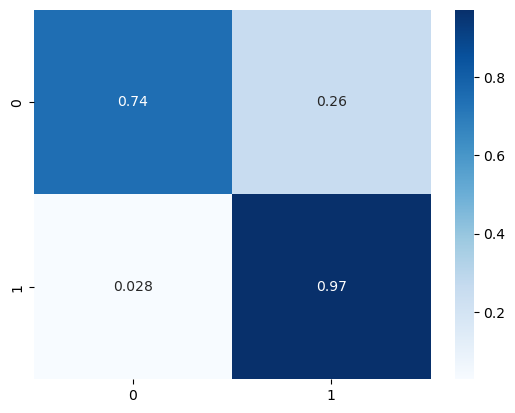

In [26]:
gbc_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42,
    max_depth=3
)
gbc_clf.fit(X_train_sample, y_train_sample)

ensemble_predictions = gbc_clf.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
cm = confusion_matrix(y_test, ensemble_predictions)
cm1 = cm / cm.sum(axis=1)[:, np.newaxis]
print(f"Ensemble Accuracy: {ensemble_accuracy}")
print("Ensemble Confusion Matrix:")
sns.heatmap(cm1, annot=True, cmap='Blues')

### XGBoost

Ensemble Accuracy: 0.8423866987559744
Ensemble Confusion Matrix:


<Axes: >

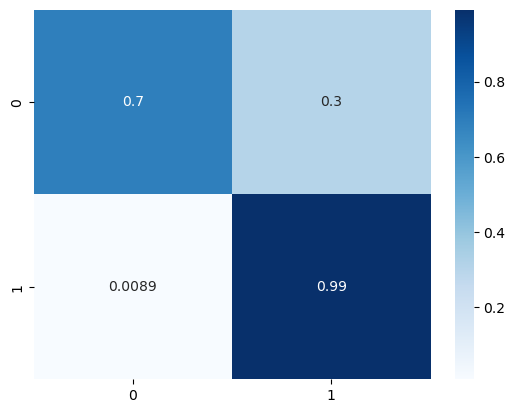

In [13]:
xgb_clf = xgb.XGBClassifier(
    max_depth=3, n_estimators=200, learning_rate=0.01, random_state=42, gamma=0.1, alpha=0.1, min_child_weight=10
)
xgb_clf.fit(X_train_sample, y_train_sample)

ensemble_predictions = xgb_clf.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
cm = confusion_matrix(y_test, ensemble_predictions)
cm1 = cm / cm.sum(axis=1)[:, np.newaxis]
print(f"Ensemble Accuracy: {ensemble_accuracy}")
print("Ensemble Confusion Matrix:")
sns.heatmap(cm1, annot=True, cmap='Blues')

## Conclusion

Los ensambles son una estrategia bastante poderosa y viable para la resolucion de estos problemas.

En este caso en particular, se demostró un mejor desempeño por las estrategias de Baggin y Voting que las de boost, una razón puede ser la cantidad limitada de información, o la poca correlacion que tienen las pocas columnas con las caracteristicas. De cualquier manera, estas estrategias siguen demostrando gran capacidad y resultan ser una muy buena opcion.